<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/07_machine_learning_intro/07_workalong01_machine_learning_basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Machine Learning Basics

This workalong walks through some of the basic elements of modern machine learning, including *rectified linear units (reLU)*, *loss functions*, *backpropagation*, and the use of `pytorch`.

## Rectified linear units (reLU)

In the cell below, implement two functions:
 1. `linear(x,w,b)`
 2. `relu(x)` 

as indicated in the functions' docstrings.  (Note, remove the lines with `pass` - this is just a line of code that says to Python "do nothing"...it's necessary because function's can't be empty in Python.)

Test that it works as expected, and keep your tests in the notebook.

In [40]:

import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cmocean #BEAUTIFUL plot colors
import numpy as np
import pandas as pd
import scipy

In [41]:
""" Define a linear and relu function. """
import numpy as np

def linear(x : np.ndarray, w : float = 1, b : float = 0) -> np.ndarray:
    """ returns w*x + b """
    return w * x + b

def relu(x : np.ndarray) -> np.ndarray:
    """ returns x if x is positive, 0 otherwise"""
    return np.maximum(0,x)



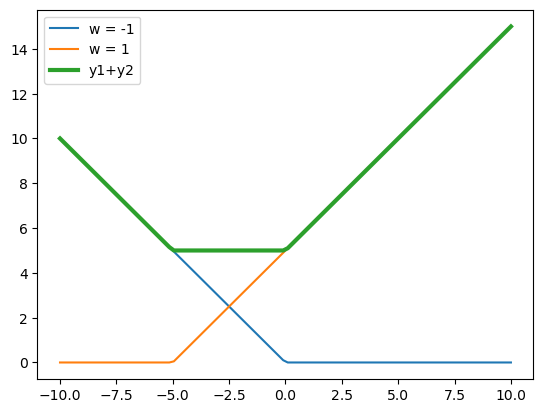

In [42]:
""" Test the relu function. """

#define x
x = np.linspace(-10,10,100)#works with 100 val as little as 5

#test relu and linear together
y1 = relu(linear(x, w = -1, b=0))
y2 = relu(linear(x, w = 1, b=5))

fig, ax = plt.subplots()

ax.plot(x,y1, label = "w = -1")
ax.plot(x,y2, label = "w = 1")
ax.plot(x,y1+y2, label = "y1+y2", linewidth = 3)
ax.legend()

plt.show()

## Fitting a function with reLUs

1. Run the cell below to create a graph of fake, noisy data (variable `noisy_data`).
1. In the cell below that, create a function `relu_sum` that is the sum of two reLUs with a bias (a scalar) added at the end
1. Create a new plot that includes the function output and the noisy data
1. Adjust the `w` and `b` parameters until the function approximates the fake data.
1. Comment in a markdown cell on your observations, what you learned, etc.



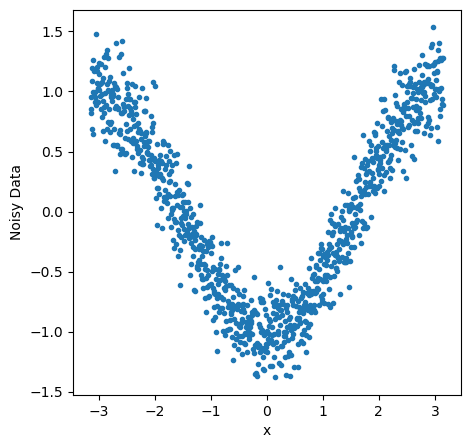

In [43]:
""" Create a fake, noisy dataset. """

# define the x values
x = np.linspace(-np.pi, np.pi, 1000)

# define the y values of the true function
y_true = -np.cos(x)

# add some noise to the true function
np.random.seed(5984)
noisy_data = y_true + np.random.normal(0, 0.2, len(x))

# plot the noisy data
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(x, noisy_data, '.', label="data")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
plt.show()

In [44]:
""" Define a function that is the sum of two relus. """

def relu_sum(x : np.ndarray, w : np.ndarray, b : np.ndarray, bias : float = 0) -> np.ndarray:
    """ returns relu(w[0]*x + b[0]) + relu(w[1]*x + b[1]) + bias """
    return relu(linear(x, w[0], b[0])) + relu(linear(x, w[1], b[1])) + bias
    

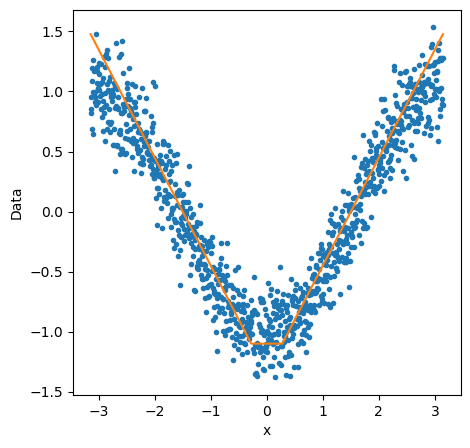

In [45]:
""" Plot the sum of two relus, with w, b such that the function fits the data. """

#manually set w, b, bias for our data
w = np.array([-0.9, 0.9])
b = np.array([0.25, 0.25])
bias = -1.6

#relu sum
z = relu_sum(x, w, b, bias)

### how to get a flat part in the middle?


# plot the noisy data
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, z, label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Data")
plt.show()

## Loss function

Now define a *loss* function $\mathcal{L}$: in this case *mean-squared error (MSE)* for the fit $\hat{\mathbf{z}}$ relative to the data $\mathbf{z}$

$$ \mathcal{L} = \frac{1}{N} \sum\limits_{i=0}^{N-1} (z_i - \hat{z}_i)^2$$

Calculate the loss for your fit to the data above: we'll compare in class.

In [46]:
""" Define a loss function. """

def loss(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """ returns the mean squared error between y_true and y_pred """
    return np.mean((y_true - y_pred)**2)


"""my try: def loss(relu_sum1, noisy_data1) -> float:
    return 1/x.shape*(sum(y**2))
    for y in noisy_data1[1]:
            y - (relu_sum1(x,w,b,bias))""" #didnt work ok


relu_loss = loss(noisy_data, z)
#loss(z, noisy_data) #<dont remember what this is for


# calculate the loss for the fit
z_fit = relu_sum(x, w, b, bias = bias)

print(f"The loss for the fit is {loss(noisy_data, z_fit):.3f}")
print(relu_loss)


The loss for the fit is 0.056
0.05628174151303437


Add the loss to the title of the plot, and vary the parameters further to see if you can minimize the loss.

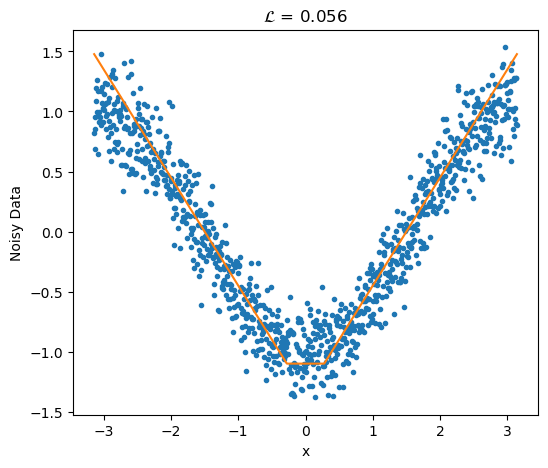

In [47]:
""" Vary parameters, minimizing the loss (include loss in title). """
# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, relu_sum(x, w, b, bias = bias), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{relu_loss:.3f}")
plt.show()


## ReLUs in `pytorch`

Now we'll take advantage of `pytorch` for automating the process of fitting a NN model.

In [48]:
""" Define a neural network with a single hidden layer. """
# import pytorch
import torch
import torch.nn as nn
# set the random seed for reproducibility
torch.manual_seed(5984)

class Net(nn.Module):

    def __init__(self, n_relus : int = 2): #int tels py that n_relus is an integer w default val 2
        #iniitalize the parent class
        super().__init__()

        #create a neural network
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_relus), #layer 1 #n_relus is our output, which is defined as having 2 parts above
            nn.ReLU(), #layer 2
            nn.Linear(n_relus, 1), #layer 3 #both a linear operation on inputs and a sum

        )
    
    def forward(self, x):
        """Define the forward pass; how the network should act like a funciton"""
        out = self.linear_relu_stack(x)
        return  out


In [49]:
test_net = Net()

x2 = torch.tensor([3.])
test_net(x2)

#inputs have to be torch tensors to work

tensor([0.3145], grad_fn=<AddBackward0>)

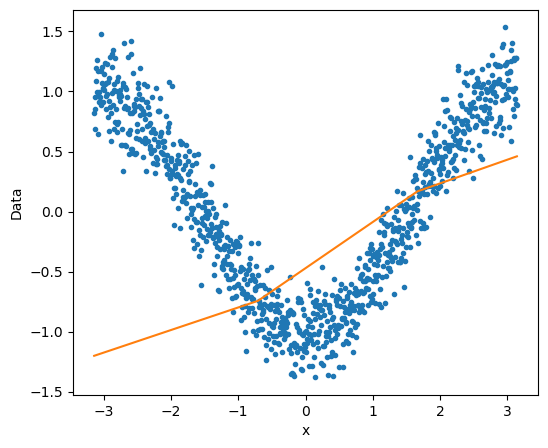

In [50]:
""" Show the initial model prediction/fit (it's bad)"""
#convert x and y vals to pytorch sensors

xt = torch.from_numpy(x).unsqueeze(1).to(torch.float32)
yt = torch.from_numpy(noisy_data).unsqueeze(1).to(torch.float32)

#create the 2 relu model
model_2 = Net(n_relus=2)


#calcualte the prediciotn
pred = model_2(xt)

# plot the noisy data
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Data")

plt.show()

### Training the model - the simple, but not-so-great way

We'll use a simple for loop to train the model on all the data.  This is bad because we don't split the dataset into train, test, and validation sets; this can make our efforts prone to overfitting.

But for simplicity, we'll forge forward with this (inadvisable) approach.

In [51]:
""" Train the model the bad way. """
#set hyperparameters
learning_rate = 0.01 #varies the jumps in relu distance in the data. one thing we mess with when fitting a model
                    #can cause model overfit
training_steps = 1000
num_relus = 2

#define the model
torch.manual_seed(5984)
model_2 = Net(n_relus = num_relus)

#define the loss funciton
loss_fn = nn.MSELoss()

#define the optimization
optim = torch.optim.Adam(model_2.parameters(), lr = learning_rate) #optimization is one of your hyperparameters. Adam is example

###the training loop
for n in range (training_steps):
    #calc prediciotn
    pred = model_2(xt)

    #calc loss
    loss = loss_fn(pred, yt)

    #reset (zero) gradients
    optim.zero_grad()

    #calculate the gradients of the parameters wrt loss
    loss.backward()

    #update parameters with the optimizer
    optim.step()
    
    #print loss every 100 steps
    if n % 100 == 0: #percent sign is shorthand of module of n divided by 100
        print(f"Step {n}: {loss.item():.3f}")




Step 0: 0.837
Step 100: 0.223
Step 200: 0.046


Step 300: 0.045
Step 400: 0.045
Step 500: 0.045
Step 600: 0.045
Step 700: 0.045
Step 800: 0.045
Step 900: 0.045


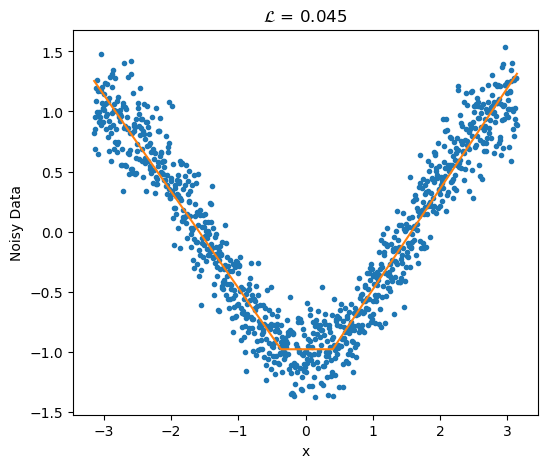

In [52]:
""" Plot the trained model. """


# calcuate the prediction
pred = model_2(xt)

# calculate the loss
loss = loss_fn(pred, yt)

# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{loss.item():.3f}")
plt.show()

### Training the model - the better, but more complicated way

We'll follow standard practice here to split the data into test, train and validation sets.  We'll also use pytorch's data loader to do training in batches, and we'll put our training loop into a function.  This will allow us to train in *epochs* (passes through the entire dataset).

In [53]:
""" Train the model the better, but more complicated way. """

# set hyperparameters
learning_rate = 0.01
num_epochs = 20
batch_size = 32
training_fraction = 0.8
test_fraction = 0.1
num_relus = 2

# define the model
# set torch's random seed for reproducibility
torch.manual_seed(5984)
model_2 = Net(n_relus = num_relus)

# set the loss function
loss_fn = nn.MSELoss()

# set the optimizer
optim = torch.optim.AdamW(model_2.parameters(), lr = learning_rate)

# set the sizes of the training, test, and validation sets
num_data_total = len(x) #total number of points
n_train = int(training_fraction * num_data_total)
n_test = int(test_fraction  * num_data_total)
n_val = num_data_total - n_train - n_test

print(f"Training on {n_train} points, testing on {n_test} points, and validating on {n_val} points.")

np.random.seed(5984)
i_random_ = np.random.choice(num_data_total, num_data_total, replace=False)

#use random indices to choose indicies for trainig test and val sets
i_train = i_random_[:n_train] #first 80% of random pts
i_test = i_random_[n_train: (n_train + n_test)] #next 10%
i_val = i_random_[(n_train + n_test):]#last 10% of random points

Training on 800 points, testing on 100 points, and validating on 100 points.


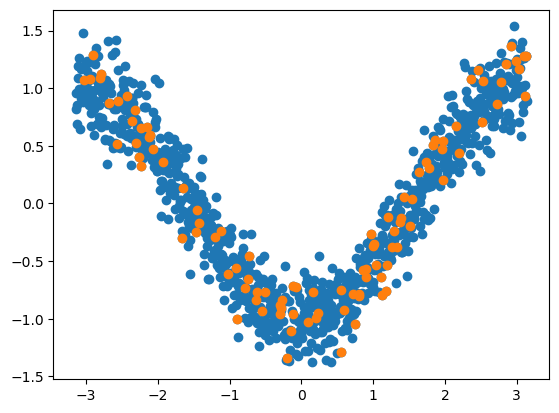

In [54]:


#chekc to see if sampling is representative shape
fix, ax = plt.subplots()

ax.scatter(x, noisy_data, label = "data")
ax.scatter(x[i_test], noisy_data[i_test], label = "test") 
    #ax.scatter(x[i_test], noisy_data, label = "test") 
    #this wasnt working before because 'x and y werent same size' error
    # so I added"[i_test]" after noisy_data. not sure if correct

ax.legend
plt.show()

shape looks representative!

In [55]:
#use random indices to choose indices for training, test, and val sets
from torch.utils.data import TensorDataset, DataLoader
x_train = xt[i_train]
y_train = yt[i_train] 
train_ds = TensorDataset(x_train, y_train)


#use random indices to split data
x_val = xt[i_val]
y_val = yt[i_val]
val_ds = TensorDataset(x_val,y_val)

#PREVIOUSLY MISSING -j
x_test = xt[i_test]
test_ds = TensorDataset(x_test, yt[i_test])

#create data loaders
train_dl = DataLoader(train_ds,batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds,batch_size = batch_size, shuffle = False)
val_dl = DataLoader(val_ds,batch_size = batch_size, shuffle = False)

def train_loop(dataloader, model, loss_fn, optim):
    """run a training loop"""
    #set the model to training mode
    model.train()

    #list losses for each
    batch_loss = []
    #loop over batches
    for batch_num, (xx,yy) in enumerate(dataloader):
        #reset zero the gradients
        optim.zero_grad()
        #run the model
        pred = model(xx)
        #calcualte the loss
        loss = loss_fn(pred, yt)
        #calculate graidents of parameters wrt loss
        loss.backward()
        #update parameters with the optimizer
        optim.step()

        #save loss in list
        batch_loss.append(loss.item())

    #calc average loss 
    avg_loss = np.mean(batch_loss)

    return avg_loss

def test_loop(dataloader, model, loss_fn):
    """run model on test dataset"""
    #model in eval mode
    model.eval()

    #initialize loss
    loss = 0

    with torch.no_grad(): #no need to calcualte gradients when testing
        #loop over the batches
        for xx, yy in dataloader:
            #calculate the prediction
            pred = model(xx)
            #calculate the loss
            loss_partial = loss_fn(pred, yy)

            #update total
            loss = loss+loss_partial

    #return the avg loss accross batches
    average_loss = loss/len(dataloader)
    return average_loss


In [56]:
"""train the model"""
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    #run teh training loop
    train_loop(train_dl, model_2, loss_fn, optim)

#run the test loop
test_loop(test_dl, model_2, loss_fn)

c:\Users\janel\.conda\envs\easg690\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (32) must match the size of tensor b (1000) at non-singleton dimension 0

In [ ]:
#but we want more than the number,we want to see our model

In [ ]:
"""train the model"""
#make lists for tracking the training loss
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    #run teh training loop
    train_loop(train_dl, model_2, loss_fn, optim)

    #add loss to the loop
    train_loss.append(loss_tmp)

    #run test loop
    loss_tmp = test_loop(test_dl, model_2, loss_fn)
    #add loss to the looop
    test_loss.append(loss_tmp)

#run the test loop
test_loop(test_dl, model_2, loss_fn)

# plot the training and test loss
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(train_loss, label="train")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

an increase in test loss shows overfitting might be occuring
everytime you do a new epoch, you want a checkpoint, because with lot of data computer might crash
and if test loss goes up, take the last checkpoint before. that is best

In [ ]:
## a word about random choice. see notation for this function
np.random.choice(100, 20, replace=False) 
#randomly chooses numbers between 0 and max numbers given 

our previous method used all data in every iteration of the data

an epoch is a full pass over the full iteration of the training set.

batch and epoch approach does not use all the data at once. here we have the training_fraction set to .8, %80 of the data will be used in training
that 80% is split into batches. each batch is trained one after the other on the model.
    keeps you from running out of memory on the dataset as well as keeping model more general

In [ ]:
""" Plot the prediction """


' Plot the prediction '